# 最大似然估计

In [1]:
from scipy.stats import lognorm, pareto, expon
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from math import exp

FONTPATH = "fonts/SourceHanSerifSC-SemiBold.otf"
mpl.font_manager.fontManager.addfont(FONTPATH)
plt.rcParams['font.family'] = ['Source Han Serif SC']

## 介绍

考虑一个政策制定者试图估算提议中的财富税将带来多少收入的情况。

提议的税务公式为：

$$
    h(w) = 
    \begin{cases}
    a w                       & \text{if } w \leq \bar w  \\
    a \bar{w} + b (w-\bar{w}) & \text{if } w > \bar w  
    \end{cases}
$$

其中 $w$ 代表财富。

```{prf:example}
:label: mle_ex_wt

例如，如果 $a = 0.05$，$b = 0.1$，且 $\bar w = 2.5$，意味着：

* 对于2.5及以下的财富征收5%的税，
* 对超过2.5的部分财富征收10%的税。

单位是100,000，所以 $w= 2.5$ 的意思是 250,000 美元。
```

让我们来定义函数 $h$:

In [2]:
def h(w, a=0.05, b=0.1, w_bar=2.5):
    if w <= w_bar:
        return a * w
    else:
        return a * w_bar + b * (w - w_bar)

对于一个人口数量为 $N$ 的社区，每个人 $i$ 拥有财富 $w_i$，通过税收收入总额为

$$
    T = \sum_{i=1}^{N} h(w_i)
$$

我们希望计算这个总量。

我们面对的问题是，在大多数国家中，并不是所有个人的财富都能被观测到。

为一个国家的所有个人或家庭收集并维持准确的财富数据是非常困难的。

因此，假设我们得到了一个样本 $w_1, w_2, \cdots, w_n$，它告诉我们 $n$ 个随机选定个人的财富。

在这个练习中，我们将使用 $n = 10,000$ 来自2016年美国的财富数据样本。

In [3]:
n = 10_000

这些数据来源于[消费者财务调查](https://en.wikipedia.org/wiki/Survey_of_Consumer_Finances) (SCF)。

以下代码导入了数据并将其读入名为 `sample` 的数组。

In [4]:
url = 'https://media.githubusercontent.com/media/QuantEcon/high_dim_data/update_scf_noweights/SCF_plus/SCF_plus_mini_no_weights.csv'
df = pd.read_csv(url)
df = df.dropna()
df = df[df['year'] == 2016]
df = df.loc[df['n_wealth'] > 1 ]   # 限制数据为净值大于 1 的数据
rv = df['n_wealth'].sample(n=n, random_state=1234)
rv = rv.to_numpy() / 100_000
sample = rv

让我们来做一个这个样本的直方图。

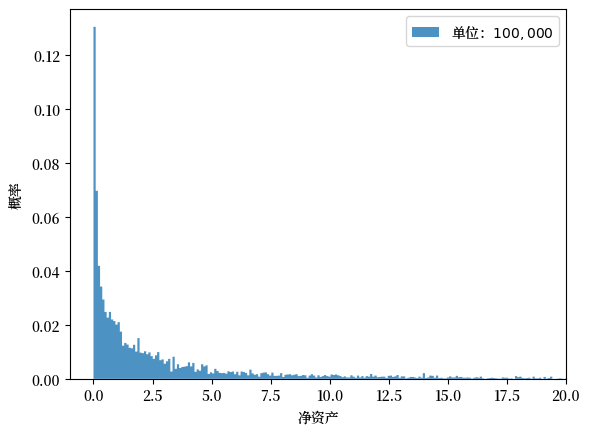

In [5]:
fig, ax = plt.subplots()
ax.set_xlim(-1, 20)
density, edges = np.histogram(sample, bins=5000, density=True)
prob = density * np.diff(edges)
plt.stairs(prob, edges, fill=True, alpha=0.8, label=r"单位：$100,000$")
plt.ylabel("概率")
plt.xlabel("净资产")
plt.legend()
plt.show()

直方图显示许多人的财富非常低，少数人的财富非常高。

我们将假定全体人口规模为

In [6]:
N = 100_000_000

我们如何仅使用样本数据来估计全体人口的总收入呢？

我们的计划是假设每个人的财富是从密度为 $f$ 的分布中抽取的。

如果我们获得 $f$ 的估计，那么我们可以按照下面的方式近似 $T$：

$$
    T = \sum_{i=1}^{N} h(w_i) 
      = N \frac{1}{N} \sum_{i=1}^{N} h(w_i) 
      \approx N \int_{0}^{\infty} h(w)f(w) dw
$$ (eq:est_rev)

（样本均值应该靠近平均值，根据大数定律。）

现在的问题是：我们如何估计 $f$？

## 最大似然估计

[最大似然估计](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) 是一种估计未知分布的方法。

最大似然估计有两个步骤：

1. 猜测潜在分布是什么（例如，正态分布，均值为 $\mu$，标准差为 $\sigma$）。
2. 估计参数值（例如，估计正态分布的 $\mu$ 和 $\sigma$）。

对于财富，一个可能的假设是每个 $w_i$ 都是[对数正态分布](https://en.wikipedia.org/wiki/Log-normal_distribution)的，参数 $\mu$ 在 $(-\infty, \infty)$ 范围内，$\sigma$ 在 $(0, \infty)$ 范围内。

（这意味着 $\ln w_i$ 是以 $\mu$ 为均值，$\sigma$ 为标准差的正态分布。）

你可以看到这个假设不是完全没有道理，因为如果我们对财富的对数进行直方图表示而不是财富本身，图片开始看起来像一个钟形曲线。

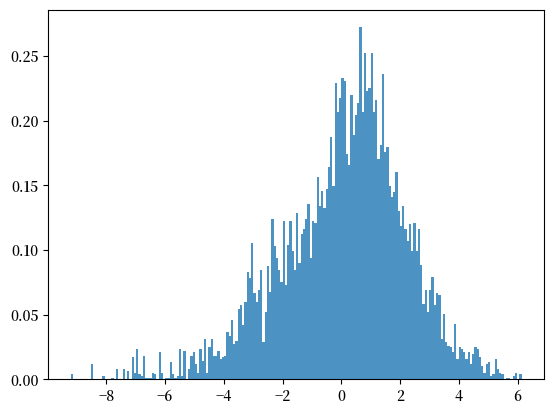

In [7]:
ln_sample = np.log(sample)
fig, ax = plt.subplots()
ax.hist(ln_sample, density=True, bins=200, histtype='stepfilled', alpha=0.8)
plt.show()

现在我们的任务是获取 $\mu$ 和 $\sigma$ 的最大似然估计，我们用 $\hat{\mu}$ 和 $\hat{\sigma}$ 表示。

这些估计值可以通过最大化给定数据的似然函数找到。

对数正态分布随机变量 $X$ 的概率密度函数 (pdf) 如下：

$$
    f(x, \mu, \sigma) 
    = \frac{1}{x}\frac{1}{\sigma \sqrt{2\pi}} 
    \exp\left(-\frac{1}{2}\left(\frac{\ln x-\mu}{\sigma}\right)^2\right)
$$

对于我们的样本 $w_1, w_2, \cdots, w_n$，[似然函数](https://en.wikipedia.org/wiki/Likelihood_function)定义为：

$$
    L(\mu, \sigma | w_i) = \prod_{i=1}^{n} f(w_i, \mu, \sigma)
$$

似然函数可以被视为：

* 样本的联合分布（假设是独立同分布）和
* 给定数据的参数 $(\mu, \sigma)$ 的“似然性”。

对两边取对数，我们得到对数似然函数，如下所示：

$$
\begin{aligned}
    \ell(\mu, \sigma | w_i) 
    & = \ln \left[ \prod_{i=1}^{n} f(w_i, \mu, \sigma) \right] \\
    & = -\sum_{i=1}^{n} \ln w_i 
        - \frac{n}{2} \ln(2\pi) - \frac{n}{2} \ln \sigma^2 - \frac{1}{2\sigma^2}
            \sum_{i=1}^n (\ln w_i - \mu)^2
\end{aligned}
$$

为了找到这个函数的最大值，我们计算关于 $\mu$ 和 $\sigma ^2$ 的偏导数，并将它们设为 $0$.

让我们首先找到 $\mu$ 的最大似然估计（MLE）

$$
\frac{\delta \ell}{\delta \mu} 
    = - \frac{1}{2\sigma^2} \times 2 \sum_{i=1}^n (\ln w_i - \mu) = 0 \\
\implies \sum_{i=1}^n \ln w_i - n \mu = 0 \\
\implies \hat{\mu} = \frac{\sum_{i=1}^n \ln w_i}{n}
$$

现在让我们找到 $\sigma$ 的MLE

$$
\frac{\delta \ell}{\delta \sigma^2} 
    = - \frac{n}{2\sigma^2} + \frac{1}{2\sigma^4} 
    \sum_{i=1}^n (\ln w_i - \mu)^2 = 0 \\
    \implies \frac{n}{2\sigma^2} = 
    \frac{1}{2\sigma^4} \sum_{i=1}^n (\ln w_i - \mu)^2 \\
    \implies \hat{\sigma} = 
    \left( \frac{\sum_{i=1}^{n}(\ln w_i - \hat{\mu})^2}{n} \right)^{1/2}
$$

现在我们已经推导出 $\hat{\mu}$ 和 $\hat{\sigma}$ 的表达式，
让我们为我们的财富样本计算它们。

In [8]:
μ_hat = np.mean(ln_sample) # 计算 μ 的估计值
μ_hat

0.0634375526654064

In [9]:
num = (ln_sample - μ_hat)**2 # 计算方差的分子部分
σ_hat = (np.mean(num))**(1/2) # 计算 σ 的估计值
σ_hat

2.1507346258433424

我们来绘制使用估计参数的对数正态分布概率密度函数，并与我们的样本数据进行对比。

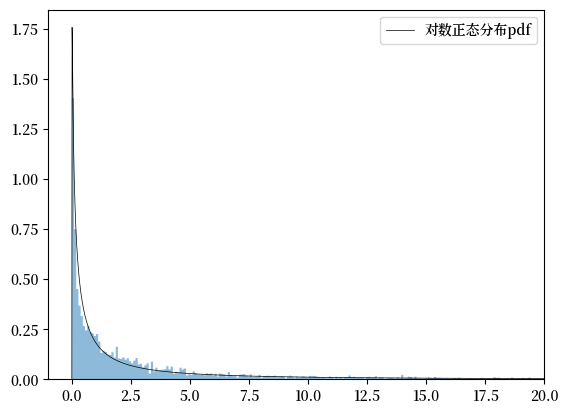

In [10]:
dist_lognorm = lognorm(σ_hat, scale = exp(μ_hat))  # 初始化对数正态分布
x = np.linspace(0,50,10000)  # 产生数据点

fig, ax = plt.subplots()  # 创建图形和轴
ax.set_xlim(-1,20)  # 设置x轴的范围

ax.hist(sample, density=True, bins=5_000, histtype='stepfilled', alpha=0.5)  # 绘制样本的直方图
ax.plot(x, dist_lognorm.pdf(x), 'k-', lw=0.5, label='对数正态分布pdf')  # 绘制对数正态分布的PDF
ax.legend()  # 显示图例
plt.show()  # 展示图形

我们的估计的对数正态分布看起来很适合整体数据。

我们现在使用方程{eq}`eq:est_rev`来计算总收入。

我们将通过 **SciPy** 的 [quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) 函数使用数值积分计算

In [11]:
def total_revenue(dist):
    integral, _ = quad(lambda x: h(x) * dist.pdf(x), 0, 100_000)  # 计算积分
    T = N * integral  # 总收入 = 人数 * 单个收入
    return T  # 返回总收入

In [12]:
tr_lognorm = total_revenue(dist_lognorm)  # 使用对数正态分布计算总收入
tr_lognorm  # 显示总收入

101105326.82814859

（我们的单位是10万美元，所以这意味着实际收入是10万倍。）

## 帕累托分布

如上所述，使用最大似然估计时需要我们假定一个先验的底层分布。

之前我们假定这个分布是对数正态分布。

假设我们改为假设 $w_i$ 来自具有参数 $b$ 和 $x_m$ 的[帕累托分布](https://en.wikipedia.org/wiki/Pareto_distribution)。

在这种情况下，最大似然估计已知为

$$
    \hat{b} = \frac{n}{\sum_{i=1}^{n} \ln (w_i/\hat{x_m})}
    \quad \text{和} \quad
    \hat{x}_m = \min_{i} w_i
$$

我们来计算它们。

In [13]:
xm_hat = min(sample)
xm_hat

0.0001

In [14]:
den = np.log(sample/xm_hat)
b_hat = 1/np.mean(den)
b_hat

0.10783091940803055

现在让我们重新计算总收入。

In [15]:
dist_pareto = pareto(b = b_hat, scale = xm_hat)
tr_pareto = total_revenue(dist_pareto) 
tr_pareto

12933168365.762571

这个数字差距很大！

In [16]:
tr_pareto / tr_lognorm

127.91777418162567

我们看到选择正确的分布非常重要。

让我们将拟合的帕累托分布与直方图进行比较：

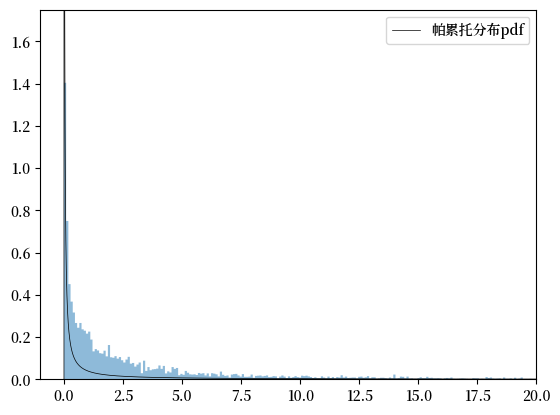

In [17]:
fig, ax = plt.subplots()
ax.set_xlim(-1, 20)
ax.set_ylim(0,1.75)

ax.hist(sample, density=True, bins=5_000, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_pareto.pdf(x), 'k-', lw=0.5, label='帕累托分布pdf')
ax.legend()

plt.show()

我们观察到在这种情况下，帕累托分布的拟合效果并不好，所以我们可能会拒绝它。

## 什么是最好的分布？

没有“最好”的分布——我们做出的每一个选择都是一种假设。

我们能做的就是尝试选择一个能很好地拟合数据的分布。

上面的图表表明，对数正态分布是最佳的。

然而，当我们检查上尾部（最富有的人）时，帕累托分布可能是一个更好的选择。

为了查看这一点，现在让我们设定一个数据集中的净资产最低阈值。

我们设定一个任意阈值为 $500,000，并将数据读入 `sample_tail`。

In [18]:
df_tail = df.loc[df['n_wealth'] > 500_000 ]
df_tail.head()
rv_tail = df_tail['n_wealth'].sample(n=10_000, random_state=4321)
rv_tail = rv_tail.to_numpy()
sample_tail = rv_tail/500_000

让我们绘制这些数据。

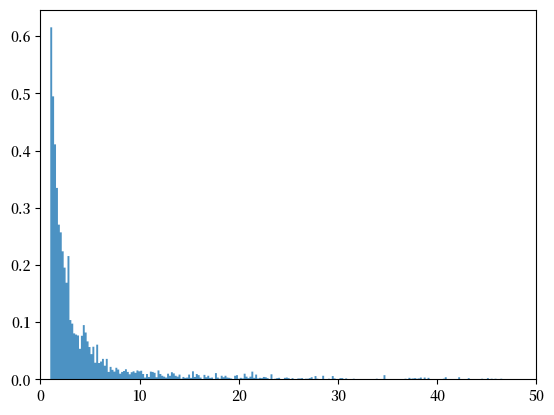

In [19]:
fig, ax = plt.subplots()
ax.set_xlim(0,50)
ax.hist(sample_tail, density=True, bins=500, histtype='stepfilled', alpha=0.8)
plt.show()

现在让我们尝试对这些数据拟合一些分布。

### 对数正态分布和右尾部

让我们从对数正态分布开始

我们再次估计参数并将密度与我们的数据进行对比。

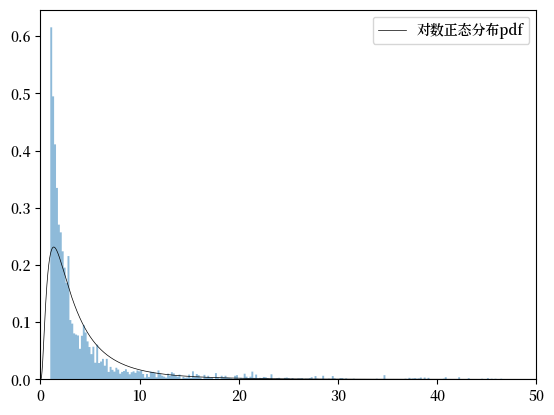

In [20]:
ln_sample_tail = np.log(sample_tail)
μ_hat_tail = np.mean(ln_sample_tail)
num_tail = (ln_sample_tail - μ_hat_tail)**2
σ_hat_tail = (np.mean(num_tail))**(1/2)
dist_lognorm_tail = lognorm(σ_hat_tail, scale = exp(μ_hat_tail))

fig, ax = plt.subplots()
ax.set_xlim(0,50)
ax.hist(sample_tail, density=True, bins=500, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_lognorm_tail.pdf(x), 'k-', lw=0.5, label='对数正态分布pdf')
ax.legend()
plt.show()

虽然对数正态分布对整个数据集拟合良好，
但它并不适合右尾部。

### 帕累托分布用于右尾部

现在假设截断数据集符合帕累托分布。

我们再次估计参数，并将密度与我们的数据进行对比。

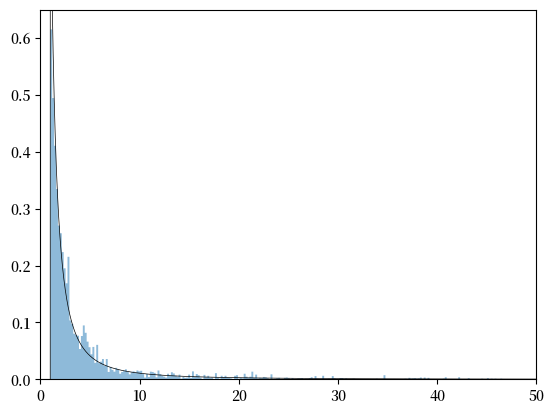

In [21]:
xm_hat_tail = min(sample_tail)
den_tail = np.log(sample_tail/xm_hat_tail)
b_hat_tail = 1/np.mean(den_tail)
dist_pareto_tail = pareto(b = b_hat_tail, scale = xm_hat_tail)

fig, ax = plt.subplots()
ax.set_xlim(0, 50)
ax.set_ylim(0,0.65)
ax.hist(sample_tail, density=True, bins= 500, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_pareto_tail.pdf(x), 'k-', lw=0.5, label='帕累托分布pdf')
plt.show()

帕累托分布更适合我们数据集的右尾部。

### 那么什么是最佳分布？

如上所述，没有“最佳”分布——每个选择都是一个假设。

我们只需要测试我们认为合理的分布。

一种测试方法是将数据与拟合分布进行绘图，正如我们所做的。

还有其他更严格的测试方法，比如[科尔莫哥洛夫-斯米尔诺夫检验](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)。

我们忽略了这些高级主题（但鼓励读者在完成这些讲座后研究它们）。

## 练习

```{exercise-start}
:label: mle_ex1
```
假设我们假设财富是以参数 $\lambda > 0$ 的[指数](https://en.wikipedia.org/wiki/Exponential_distribution)分布。

$\lambda$ 的最大似然估计为

$$
\hat{\lambda} = \frac{n}{\sum_{i=1}^n w_i}
$$

1. 计算我们初始样本的 $\hat{\lambda}$。
2. 使用 $\hat{\lambda}$ 来找到总收入

```{exercise-end}
```

```{solution-start} mle_ex1
:class: dropdown
```

In [22]:
λ_hat = 1/np.mean(sample)
λ_hat

0.15234120963403971

In [23]:
dist_exp = expon(scale = 1/λ_hat)
tr_expo = total_revenue(dist_exp) 
tr_expo

55246978.53427645

```{solution-end}
```

```{exercise-start}
:label: mle_ex2
```

绘制指数分布与样本的比较，并检查它是否适合。

```{exercise-end}
```

```{solution-start} mle_ex2
:class: dropdown
```

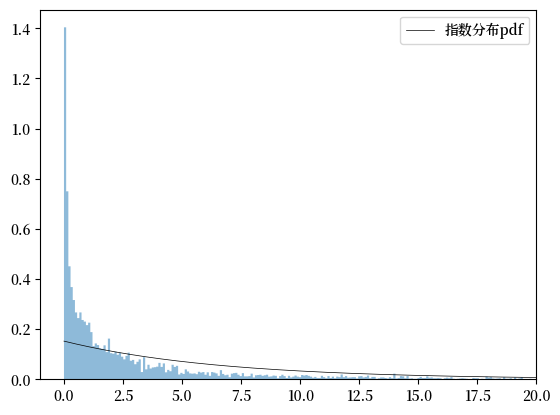

In [24]:
fig, ax = plt.subplots()
ax.set_xlim(-1, 20)

ax.hist(sample, density=True, bins=5000, histtype='stepfilled', alpha=0.5)
ax.plot(x, dist_exp.pdf(x), 'k-', lw=0.5, label='指数分布pdf')
ax.legend()

plt.show()

很明显，这个分布不适合我们的数据。

```{solution-end}
```